In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [3]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [4]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional
import warnings
warnings.filterwarnings('ignore')

def analyze_tcp_hooks(data: Dict, workload_name: str = "Workload"):
    print(f"\n{'='*80}")
    print(f"TCP ANALYSIS: {workload_name.upper()}")
    print(f"{'='*80}")
    
    # Load data safely from all hooks
    tcp_rcv_df = None
    tcp_state_df = None  
    tcp_connect_df = None
    tcp_cc_df = None
    tcp_cubic_df = None
    
    if "tcp_v4_rcv" in data and len(data["tcp_v4_rcv"]) > 0:
        tcp_rcv_df = pl.read_parquet(data["tcp_v4_rcv"][0])
        tcp_rcv_df = tcp_rcv_df.filter(pl.col('comm').str.contains(workload_name))
        print(f"✓ Loaded tcp_v4_rcv: {len(tcp_rcv_df):,} events")
    else:
        print("✗ No tcp_v4_rcv data")
    
    if "tcp_state_process" in data and len(data["tcp_state_process"]) > 0:
        tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])
        tcp_state_df = tcp_state_df.filter(pl.col('comm').str.contains(workload_name))
        print(f"✓ Loaded tcp_state_process: {len(tcp_state_df):,} events")
    else:
        print("✗ No tcp_state_process data")
    
    if "tcp_v4_connect" in data and len(data["tcp_v4_connect"]) > 0:
        tcp_connect_df = pl.read_parquet(data["tcp_v4_connect"][0])
        tcp_connect_df = tcp_connect_df.filter(pl.col('comm').str.contains(workload_name))
        print(f"✓ Loaded tcp_v4_connect: {len(tcp_connect_df):,} events")
    else:
        print("✗ No tcp_v4_connect data")

    if "tcp_congestion_control" in data and len(data["tcp_congestion_control"]) > 0:
        tcp_cc_df = pl.read_parquet(data["tcp_congestion_control"][0])
        tcp_cc_df = tcp_cc_df.filter(pl.col('comm').str.contains(workload_name))
        print(f"✓ Loaded tcp_congestion_control: {len(tcp_cc_df):,} events")
    else:
        print("✗ No tcp_congestion_control data")
    
    if "tcp_cubic" in data and len(data["tcp_cubic"]) > 0:
        tcp_cubic_df = pl.read_parquet(data["tcp_cubic"][0])
        tcp_cubic_df = tcp_cubic_df.filter(pl.col('comm').str.contains(workload_name))
        print(f"✓ Loaded tcp_cubic: {len(tcp_cubic_df):,} events")
    else:
        print("✗ No tcp_cubic data")
    
    # =========================================================================
    # 1. TCP v4 Receive Analysis (Packet Processing)
    # =========================================================================
    if tcp_rcv_df is not None and len(tcp_rcv_df) > 0:
        print(f"\n[1] TCP PACKET RECEIVE (tcp_v4_rcv)")
        print("-" * 40)
        
        entry_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "entry"))
        print(f"Packets received (entry events): {entry_count:,}")
        print(f"Total events recorded: {len(tcp_rcv_df):,}")
        print(f"Events per packet: {len(tcp_rcv_df)/entry_count:.2f}" if entry_count > 0 else "N/A")
        
        if entry_count > 0:
            # Calculate branch distribution with entry as denominator
            print(f"\nBranch Distribution (% of packets):")
            branch_dist = tcp_rcv_df.group_by("branch_name").agg([
                pl.count().alias("count")
            ]).with_columns([
                (pl.col("count") * 100.0 / entry_count).alias("pct_of_packets"),
                (pl.col("count") * 100.0 / len(tcp_rcv_df)).alias("pct_of_events")
            ]).sort("count", descending=True)
            
            for row in branch_dist.head(10).iter_rows():
                branch, count, pct_packets, pct_events = row
                # Show both percentages for clarity
                print(f"  {branch:20s}: {count:6d} ({pct_packets:5.1f}% of packets)")
            
            # Performance metrics
            print(f"\nPerformance Metrics:")
            
            # Fast path (direct processing)
            fast_path = ["do_rcv_direct", "established_proc"]
            fast_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(fast_path)))
            print(f"  Fast path: {fast_count:,} ({fast_count/entry_count*100:.1f}% of packets)")
            
            # Slow path (backlog)
            slow_path = ["socket_busy", "backlog_add"]
            slow_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(slow_path)))
            print(f"  Slow path: {slow_count:,} ({slow_count/entry_count*100:.1f}% of packets)")
            
            # Listen processing
            listen_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "listen_state"))
            print(f"  Listen state: {listen_count:,} ({listen_count/entry_count*100:.1f}% of packets)")
            
            # Drops
            drops = tcp_rcv_df.filter(pl.col("drop_reason") > 0)
            if len(drops) > 0:
                drop_rate = len(drops) / entry_count * 100
                print(f"  Dropped: {len(drops):,} ({drop_rate:.2f}% drop rate)")
                
                print(f"\n  Drop Reasons:")
                drop_dist = drops.group_by("drop_reason_name").count().sort("count", descending=True)
                for row in drop_dist.iter_rows():
                    print(f"    {row[0]:20s}: {row[1]:4d}")
            else:
                print(f"  ✓ No packet drops")
            
            # Process breakdown
            print(f"\nTop Processes:")
            proc_dist = tcp_rcv_df.filter(pl.col("branch_name") == "entry").group_by("comm").count().sort("count", descending=True)
            for row in proc_dist.head(5).iter_rows():
                print(f"  {row[0]:20s}: {row[1]:6d} packets")
    
    # =========================================================================
    # 2. TCP State Process Analysis (State Machine)
    # =========================================================================
    if tcp_state_df is not None and len(tcp_state_df) > 0:
        print(f"\n[2] TCP STATE MACHINE (tcp_state_process)")
        print("-" * 40)
        
        # Event type breakdown
        event_dist = tcp_state_df.group_by("event_type_name").count().sort("count", descending=True)
        print(f"Event Types:")
        for row in event_dist.iter_rows():
            print(f"  {row[0]:15s}: {row[1]:6d}")
        
        # State transitions
        transitions = tcp_state_df.filter(pl.col("event_type_name") == "TRANSITION")
        if len(transitions) > 0:
            print(f"\nState Transitions: {len(transitions):,}")
            
            # Create transition strings
            trans_summary = transitions.select([
                pl.concat_str([
                    pl.col("old_state_name"),
                    pl.lit(" → "),
                    pl.col("new_state_name")
                ]).alias("transition")
            ]).group_by("transition").count().sort("count", descending=True)
            
            print(f"Top Transitions:")
            for row in trans_summary.head(10).iter_rows():
                print(f"  {row[0]:35s}: {row[1]:4d}")
            
            # Connection lifecycle analysis
            print(f"\nConnection Lifecycle:")
            
            # New connections
            new_conn = len(transitions.filter(
                (pl.col("old_state_name") == "LISTEN") & 
                (pl.col("new_state_name") == "SYN_RECV")
            ))
            
            # Established
            established = len(transitions.filter(pl.col("new_state_name") == "ESTABLISHED"))
            
            # Terminating
            fin_wait = len(transitions.filter(pl.col("new_state_name").str.contains("FIN_WAIT")))
            time_wait = len(transitions.filter(pl.col("new_state_name") == "TIME_WAIT"))
            closed = len(transitions.filter(pl.col("new_state_name").str.contains("CLOSE")))
            
            print(f"  New connections: {new_conn}")
            print(f"  Established: {established}")
            print(f"  FIN_WAIT: {fin_wait}")
            print(f"  TIME_WAIT: {time_wait}")
            print(f"  Closed: {closed}")
            
            # Connection health check
            if established > 0:
                proper_close = (time_wait + closed) / established * 100
                print(f"  Connection closure rate: {proper_close:.1f}%")
                if proper_close < 80:
                    print(f"  ⚠ Possible connection leak")
    
    # =========================================================================
    # 3. TCP v4 Connect Analysis (Connection Establishment)
    # =========================================================================
    if tcp_connect_df is not None and len(tcp_connect_df) > 0:
        print(f"\n[3] TCP CONNECTION ESTABLISHMENT (tcp_v4_connect)")
        print("-" * 40)
        
        # CRITICAL: Use entry count as denominator
        if "branch_name" in tcp_connect_df.columns:
            entry_count = len(tcp_connect_df.filter(pl.col("branch_name") == "entry"))
            print(f"Connection attempts (entry events): {entry_count:,}")
            print(f"Total events recorded: {len(tcp_connect_df):,}")
            
            if entry_count > 0:
                # Branch distribution
                print(f"\nBranch Distribution (% of attempts):")
                branch_dist = tcp_connect_df.group_by("branch_name").agg([
                    pl.count().alias("count")
                ]).with_columns([
                    (pl.col("count") * 100.0 / entry_count).alias("pct_of_attempts")
                ]).sort("count", descending=True)
                
                for row in branch_dist.head(10).iter_rows():
                    branch, count, pct = row
                    print(f"  {branch:20s}: {count:6d} ({pct:5.1f}% of attempts)")
                
                # Path analysis
                if "path_name" in tcp_connect_df.columns:
                    print(f"\nConnection Paths:")
                    path_dist = tcp_connect_df.group_by("path_name").count().sort("count", descending=True)
                    for row in path_dist.iter_rows():
                        print(f"  {row[0]:15s}: {row[1]:6d}")
                
                # Success/failure analysis
                if "error_code" in tcp_connect_df.columns:
                    success = len(tcp_connect_df.filter(pl.col("error_code") == 0))
                    failed = len(tcp_connect_df.filter(pl.col("error_code") != 0))
                    
                    print(f"\nConnection Results:")
                    print(f"  Successful: {success:,} ({success/entry_count*100:.1f}% success rate)")
                    print(f"  Failed: {failed:,} ({failed/entry_count*100:.1f}% failure rate)")
                    
                    if failed > 0:
                        print(f"\n  Failure Reasons:")
                        error_dist = tcp_connect_df.filter(pl.col("error_code") != 0).group_by("error_name").count().sort("count", descending=True)
                        for row in error_dist.head(5).iter_rows():
                            print(f"    {row[0]:20s}: {row[1]:4d}")
                
                # Latency analysis
                if "latency_ns" in tcp_connect_df.columns:
                    latencies = tcp_connect_df.filter(pl.col("latency_ns") > 0)["latency_ns"]
                    if len(latencies) > 0:
                        print(f"\nConnection Latency:")
                        print(f"  Average: {latencies.mean()/1000:.1f} μs")
                        print(f"  Median: {latencies.median()/1000:.1f} μs")
                        print(f"  P95: {latencies.quantile(0.95)/1000:.1f} μs")
                        print(f"  P99: {latencies.quantile(0.99)/1000:.1f} μs")
                        print(f"  Max: {latencies.max()/1000:.1f} μs")
    
    # =========================================================================
    # 4. TCP Congestion Control Analysis (Algorithm Assignment)
    # =========================================================================
    if tcp_cc_df is not None and len(tcp_cc_df) > 0:
        print(f"\n[4] TCP CONGESTION CONTROL (tcp_congestion_control)")
        print("-" * 40)

        event_dist = tcp_cc_df.group_by("event_type_name").count().sort("count", descending=True)
        print("Event Types:")
        for row in event_dist.iter_rows():
            print(f"  {row[0]:10s}: {row[1]:6d}")

        algo_dist = tcp_cc_df.group_by("ca_name").count().sort("count", descending=True)
        print("\nCongestion Algorithms:")
        for row in algo_dist.iter_rows():
            print(f"  {row[0]:15s}: {row[1]:6d}")
    
    # =========================================================================
    # 5. TCP CUBIC Analysis (CUBIC-specific Metrics)
    # =========================================================================
    if tcp_cubic_df is not None and len(tcp_cubic_df) > 0:
        print(f"\n[5] TCP CUBIC METRICS (tcp_cubic)")
        print("-" * 40)
        
        # Event type distribution
        event_dist = tcp_cubic_df.group_by("event_type_name").count().sort("count", descending=True)
        print(f"CUBIC Event Types:")
        for row in event_dist.iter_rows():
            print(f"  {row[0]:15s}: {row[1]:6d}")
        
        # Congestion avoidance events (most frequent)
        cong_avoid_events = tcp_cubic_df.filter(pl.col("event_type_name") == "CONG_AVOID")
        if len(cong_avoid_events) > 0:
            print(f"\nCongestion Avoidance Analysis:")
            print(f"  Total CA events: {len(cong_avoid_events):,}")
            
            # CWND statistics
            cwnd_stats = cong_avoid_events["cwnd"]
            print(f"\n  CWND (packets):")
            print(f"    Mean: {cwnd_stats.mean():.1f}")
            print(f"    Median: {cwnd_stats.median():.1f}")
            print(f"    Min: {cwnd_stats.min()}")
            print(f"    Max: {cwnd_stats.max()}")
            print(f"    StdDev: {cwnd_stats.std():.1f}")
            
            # Slow start vs congestion avoidance
            slow_start = cong_avoid_events.filter(pl.col("in_slow_start") == 1)
            cong_avoid = cong_avoid_events.filter(pl.col("in_slow_start") == 0)
            
            print(f"\n  Phase Distribution:")
            print(f"    Slow Start: {len(slow_start):,} ({len(slow_start)/len(cong_avoid_events)*100:.1f}%)")
            print(f"    Congestion Avoidance: {len(cong_avoid):,} ({len(cong_avoid)/len(cong_avoid_events)*100:.1f}%)")
            
            # TCP friendliness
            tcp_friendly = cong_avoid_events.filter(pl.col("is_tcp_friendly") == 1)
            print(f"\n  TCP Friendliness:")
            print(f"    TCP-friendly mode: {len(tcp_friendly):,} ({len(tcp_friendly)/len(cong_avoid_events)*100:.1f}%)")
            
            # RTT analysis
            rtt_stats = cong_avoid_events.filter(pl.col("rtt_us") > 0)["rtt_us"]
            if len(rtt_stats) > 0:
                print(f"\n  RTT Statistics (μs):")
                print(f"    Mean: {rtt_stats.mean():.1f}")
                print(f"    Median: {rtt_stats.median():.1f}")
                print(f"    Min: {rtt_stats.min()}")
                print(f"    Max: {rtt_stats.max()}")
                print(f"    P95: {rtt_stats.quantile(0.95):.1f}")
                print(f"    P99: {rtt_stats.quantile(0.99):.1f}")
            
            # CUBIC-specific metrics
            print(f"\n  CUBIC Algorithm Metrics:")
            
            # K value (distance to Wmax)
            k_values = cong_avoid_events.filter(pl.col("bic_K") > 0)["bic_K"]
            if len(k_values) > 0:
                print(f"    K value (distance to Wmax):")
                print(f"      Mean: {k_values.mean():.1f}")
                print(f"      Median: {k_values.median():.1f}")
            
            # cnt (CUBIC increment counter)
            cnt_values = cong_avoid_events.filter(pl.col("cnt") > 0)["cnt"]
            if len(cnt_values) > 0:
                print(f"    cnt (increment counter):")
                print(f"      Mean: {cnt_values.mean():.1f}")
                print(f"      Median: {cnt_values.median():.1f}")
            
            # Delay min (baseline RTT)
            delay_min_values = cong_avoid_events.filter(pl.col("delay_min") > 0)["delay_min"]
            if len(delay_min_values) > 0:
                print(f"    delay_min (baseline RTT):")
                print(f"      Mean: {delay_min_values.mean():.1f} μs")
                print(f"      Min: {delay_min_values.min()} μs")
        
        # Loss events analysis
        loss_events = tcp_cubic_df.filter(pl.col("event_type_name") == "SSTHRESH")
        if len(loss_events) > 0:
            print(f"\nLoss Detection Events:")
            print(f"  Total loss events: {len(loss_events):,}")
            
            # CWND reduction
            if len(loss_events.filter(pl.col("cwnd") > 0)) > 0:
                cwnd_at_loss = loss_events.filter(pl.col("cwnd") > 0)["cwnd"]
                ssthresh_at_loss = loss_events.filter(pl.col("ssthresh") > 0)["ssthresh"]
                
                print(f"  CWND at loss:")
                print(f"    Mean: {cwnd_at_loss.mean():.1f}")
                print(f"    Max: {cwnd_at_loss.max()}")
                
                if len(ssthresh_at_loss) > 0:
                    print(f"  New ssthresh:")
                    print(f"    Mean: {ssthresh_at_loss.mean():.1f}")
                    print(f"    Min: {ssthresh_at_loss.min()}")
        
        # HyStart detection
        hystart_events = tcp_cubic_df.filter(pl.col("event_type_name") == "HYSTART")
        if len(hystart_events) > 0:
            print(f"\nHyStart Detection:")
            print(f"  HyStart events: {len(hystart_events):,}")
            found_events = hystart_events.filter(pl.col("found") == 1)
            if len(found_events) > 0:
                print(f"  Exit slow start early: {len(found_events):,} ({len(found_events)/len(hystart_events)*100:.1f}%)")
        
        # Per-connection analysis
        if len(tcp_cubic_df) > 100:  # Only if we have enough data
            print(f"\nPer-Connection CUBIC Metrics:")
            
            # Group by connection
            conn_stats = tcp_cubic_df.filter(pl.col("event_type_name") == "CONG_AVOID").group_by(
                ["saddr", "daddr", "sport", "dport"]
            ).agg([
                pl.count().alias("events"),
                pl.col("cwnd").max().alias("max_cwnd"),
                pl.col("cwnd").mean().alias("avg_cwnd"),
                pl.col("rtt_us").mean().alias("avg_rtt"),
                pl.col("retrans_out").max().alias("max_retrans"),
                pl.col("in_slow_start").mean().alias("slow_start_ratio"),
            ]).sort("events", descending=True)
            
            print(f"  Top connections by activity:")
            for row in conn_stats.head(5).iter_rows():
                saddr, daddr, sport, dport, events, max_cwnd, avg_cwnd, avg_rtt, max_retrans, ss_ratio = row
                print(f"    {saddr}:{sport} → {daddr}:{dport}")
                print(f"      Events: {events:,}, Max CWND: {max_cwnd}, Avg RTT: {avg_rtt:.0f}μs")
                print(f"      Retransmits: {max_retrans}, Slow start: {ss_ratio*100:.1f}%")
        
        # Visualizations
        if len(cong_avoid_events) > 100:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle("TCP CUBIC Metrics", fontsize=16)
            
            # CWND distribution
            axes[0, 0].hist(cong_avoid_events["cwnd"], bins=50, edgecolor='black')
            axes[0, 0].set_xlabel("CWND (packets)")
            axes[0, 0].set_ylabel("Frequency")
            axes[0, 0].set_title("CWND Distribution")
            axes[0, 0].axvline(cong_avoid_events["cwnd"].mean(), color='red', linestyle='--', label=f'Mean: {cong_avoid_events["cwnd"].mean():.1f}')
            axes[0, 0].legend()
            
            # RTT distribution
            rtt_data = cong_avoid_events.filter(pl.col("rtt_us") > 0)["rtt_us"]
            if len(rtt_data) > 0:
                axes[0, 1].hist(rtt_data / 1000, bins=50, edgecolor='black')  # Convert to ms
                axes[0, 1].set_xlabel("RTT (ms)")
                axes[0, 1].set_ylabel("Frequency")
                axes[0, 1].set_title("RTT Distribution")
                axes[0, 1].axvline(rtt_data.mean() / 1000, color='red', linestyle='--', label=f'Mean: {rtt_data.mean()/1000:.1f}ms')
                axes[0, 1].legend()
            
            # Phase distribution (pie chart)
            phase_counts = [len(slow_start), len(cong_avoid)]
            phase_labels = ['Slow Start', 'Congestion Avoidance']
            colors = ['lightgreen', 'lightcoral']
            axes[1, 0].pie(phase_counts, labels=phase_labels, colors=colors, autopct='%1.1f%%', startangle=90)
            axes[1, 0].set_title("Phase Distribution")
            
            # CWND over time (sample)
            sample_df = cong_avoid_events.head(1000).with_row_count("idx")
            axes[1, 1].plot(sample_df["idx"], sample_df["cwnd"], alpha=0.7)
            axes[1, 1].set_xlabel("Event Index (sample)")
            axes[1, 1].set_ylabel("CWND (packets)")
            axes[1, 1].set_title("CWND Evolution (first 1000 events)")
            axes[1, 1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # =========================================================================
    # 6. Cross-Hook Correlation Analysis
    # =========================================================================
    print(f"\n[6] CROSS-HOOK ANALYSIS")
    print("-" * 40)
    
    # Correlate congestion control with CUBIC metrics
    if tcp_cc_df is not None and tcp_cubic_df is not None:
        print(f"Congestion Control Correlation:")
        
        # Check if CUBIC is being used
        cubic_usage = tcp_cc_df.filter(pl.col("ca_name") == "cubic")
        if len(cubic_usage) > 0:
            print(f"  CUBIC algorithm assignments: {len(cubic_usage):,}")
            print(f"  CUBIC metric events: {len(tcp_cubic_df):,}")
            print(f"  Events per assignment: {len(tcp_cubic_df)/len(cubic_usage):.1f}")
    
    # Calculate overall health score
    health_score = 100
    issues = []
    
    if tcp_rcv_df is not None and len(tcp_rcv_df) > 0:
        entry_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "entry"))
        if entry_count > 0:
            # Check for drops
            drops = len(tcp_rcv_df.filter(pl.col("drop_reason") > 0))
            if drops > 0:
                drop_rate = drops / entry_count * 100
                health_score -= min(20, drop_rate * 10)
                issues.append(f"Packet drops: {drop_rate:.2f}%")
            
            # Check for backlog pressure
            slow_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(["socket_busy", "backlog_add"])))
            if slow_count > entry_count * 0.1:
                health_score -= 10
                issues.append(f"High backlog: {slow_count/entry_count*100:.1f}%")
    
    if tcp_connect_df is not None and "error_code" in tcp_connect_df.columns:
        entry_count = len(tcp_connect_df.filter(pl.col("branch_name") == "entry")) if "branch_name" in tcp_connect_df.columns else len(tcp_connect_df)
        if entry_count > 0:
            failures = len(tcp_connect_df.filter(pl.col("error_code") != 0))
            if failures > 0:
                fail_rate = failures / entry_count * 100
                health_score -= min(20, fail_rate * 5)
                issues.append(f"Connection failures: {fail_rate:.1f}%")
    
    # Check CUBIC performance
    if tcp_cubic_df is not None and len(tcp_cubic_df) > 0:
        loss_events = tcp_cubic_df.filter(pl.col("event_type_name") == "SSTHRESH")
        if len(loss_events) > 0:
            cong_avoid_events = tcp_cubic_df.filter(pl.col("event_type_name") == "CONG_AVOID")
            if len(cong_avoid_events) > 0:
                loss_rate = len(loss_events) / len(cong_avoid_events) * 100
                if loss_rate > 1:
                    health_score -= min(15, loss_rate * 5)
                    issues.append(f"High loss rate: {loss_rate:.2f}%")
        
        # Check if mostly in slow start (might indicate poor network)
        if len(cong_avoid_events) > 0:
            slow_start_ratio = len(cong_avoid_events.filter(pl.col("in_slow_start") == 1)) / len(cong_avoid_events)
            if slow_start_ratio > 0.8:
                health_score -= 10
                issues.append(f"Excessive slow start: {slow_start_ratio*100:.1f}%")
    
    print(f"Overall Health Score: {max(0, health_score)}/100")
    if issues:
        print(f"Issues Found:")
        for issue in issues:
            print(f"  • {issue}")
    else:
        print(f"✓ No significant issues detected")
    
    # Performance recommendations
    print(f"\nRecommendations:")
    if tcp_rcv_df is not None:
        entry_count = len(tcp_rcv_df.filter(pl.col("branch_name") == "entry"))
        if entry_count > 0:
            slow_count = len(tcp_rcv_df.filter(pl.col("branch_name").is_in(["socket_busy", "backlog_add"])))
            if slow_count > entry_count * 0.1:
                print(f"  • Increase socket buffer: sysctl -w net.core.rmem_max=134217728")
            
            drops = len(tcp_rcv_df.filter(pl.col("drop_reason") > 0))
            if drops > 0:
                print(f"  • Check network interface: ethtool -S <interface>")
                print(f"  • Review firewall rules: iptables -L -n -v")
    
    if tcp_connect_df is not None and "error_code" in tcp_connect_df.columns:
        failures = tcp_connect_df.filter(pl.col("error_code") != 0)
        if len(failures) > 0:
            if "ENETUNREACH" in failures["error_name"].to_list() if "error_name" in failures.columns else []:
                print(f"  • Check routing: ip route show")
            if "EADDRINUSE" in failures["error_name"].to_list() if "error_name" in failures.columns else []:
                print(f"  • Check port usage: ss -tulpn")
    
    # CUBIC-specific recommendations
    if tcp_cubic_df is not None and len(tcp_cubic_df) > 0:
        loss_events = tcp_cubic_df.filter(pl.col("event_type_name") == "SSTHRESH")
        if len(loss_events) > 10:
            print(f"  • High loss detected, consider:")
            print(f"    - Check network congestion: tc -s qdisc show")
            print(f"    - Tune CUBIC parameters: sysctl net.ipv4.tcp_congestion_control")
        
        cong_avoid_events = tcp_cubic_df.filter(pl.col("event_type_name") == "CONG_AVOID")
        if len(cong_avoid_events) > 0:
            avg_cwnd = cong_avoid_events["cwnd"].mean()
            if avg_cwnd < 10:
                print(f"  • Low average CWND ({avg_cwnd:.1f}), consider:")
                print(f"    - Increase initial window: sysctl -w net.ipv4.tcp_init_cwnd=10")
            
            slow_start_ratio = len(cong_avoid_events.filter(pl.col("in_slow_start") == 1)) / len(cong_avoid_events)
            if slow_start_ratio > 0.8:
                print(f"  • Excessive slow start, consider:")
                print(f"    - Enable HyStart: sysctl -w net.ipv4.tcp_cubic_hystart=1")
                print(f"    - Tune slow start threshold")
    
    return {
        "tcp_rcv_df": tcp_rcv_df,
        "tcp_state_df": tcp_state_df,
        "tcp_connect_df": tcp_connect_df,
        "tcp_cc_df": tcp_cc_df,
        "tcp_cubic_df": tcp_cubic_df,
        "health_score": health_score,
        "issues": issues
    }

In [5]:
import subprocess
import sys


# New TCP Collector
collect = Collector("./config/raw_overrides.yaml")
collect.start_collection()

# Generate some TCP traffic
!nc -l 8080 &  # Listen on port 8080
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 

data = collect.stop_collection()

In [6]:
data

{'tcp_v4_connect': [PosixPath('data/curated/faux/64896216-f0ba-48b3-9814-84bbf95f0dd7/tcp_v4_connect.end.parquet')],
 'system_info': [PosixPath('data/curated/faux/64896216-f0ba-48b3-9814-84bbf95f0dd7/system_info.end.parquet')],
 'tcp_v4_rcv': [PosixPath('data/curated/faux/64896216-f0ba-48b3-9814-84bbf95f0dd7/tcp_v4_rcv.end.parquet')],
 'tcp_state_process': [PosixPath('data/curated/faux/64896216-f0ba-48b3-9814-84bbf95f0dd7/tcp_state_process.end.parquet')],
 'tcp_cubic': [PosixPath('data/curated/faux/64896216-f0ba-48b3-9814-84bbf95f0dd7/tcp_cubic.end.parquet')],
 'tcp_congestion_control': [PosixPath('data/curated/faux/64896216-f0ba-48b3-9814-84bbf95f0dd7/tcp_congestion_control.end.parquet')]}

In [7]:
nc_data = analyze_tcp_hooks(data, "nc")


TCP ANALYSIS: NC
✓ Loaded tcp_v4_rcv: 42 events
✓ Loaded tcp_state_process: 18 events
✓ Loaded tcp_v4_connect: 72 events
✓ Loaded tcp_congestion_control: 12 events
✓ Loaded tcp_cubic: 0 events

[1] TCP PACKET RECEIVE (tcp_v4_rcv)
----------------------------------------
Packets received (entry events): 12
Total events recorded: 42
Events per packet: 3.50

Branch Distribution (% of packets):
  entry               :     12 (100.0% of packets)
  time_wait           :      6 ( 50.0% of packets)
  no_socket           :      6 ( 50.0% of packets)
  established_proc    :      6 ( 50.0% of packets)
  new_syn_recv        :      6 ( 50.0% of packets)
  socket_busy         :      6 ( 50.0% of packets)

Performance Metrics:
  Fast path: 6 (50.0% of packets)
  Slow path: 6 (50.0% of packets)
  Listen state: 0 (0.0% of packets)
  Dropped: 6 (50.00% drop rate)

  Drop Reasons:
    no_socket           :    6

Top Processes:
  nc                  :     12 packets

[2] TCP STATE MACHINE (tcp_state_proc

In [8]:
# Simple iperf3 Test - Docker Friendly Version

import subprocess
import time

# First, let's manually test if iperf3 works
print("Testing iperf3 installation...")

# Install iperf3 if needed
install_result = subprocess.run(["which", "iperf3"], capture_output=True)
if install_result.returncode != 0:
    print("Installing iperf3...")
    subprocess.run(["apt-get", "update"], capture_output=True)
    subprocess.run(["apt-get", "install", "-y", "iperf3"], capture_output=True)
    print("iperf3 installed!")
else:
    print("iperf3 is already installed")

# Kill any existing iperf3 processes
subprocess.run(["pkill", "-f", "iperf3"], capture_output=True)
time.sleep(1)

# Start iperf3 server manually
print("\nStarting iperf3 server on port 5555...")
server = subprocess.Popen(
    ["iperf3", "-s", "-p", "5555"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for server
time.sleep(3)

# Test connection
print("Testing server connection...")
test = subprocess.run(
    ["iperf3", "-c", "127.0.0.1", "-p", "5555", "-t", "1"],
    capture_output=True,
    text=True
)

if test.returncode == 0:
    print("✓ iperf3 is working!")
    
    # Now run actual benchmark with kernmlops
    print("\nRunning benchmark with kernmlops...")
    
    # Use minimal config for Docker
    collect = Collector("./config/iperf_docker.yaml")
    
    try:
        collect.start_collection(None)
        data = collect.wait()
        
        import polars as pl
        tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])
        print(f"\n✓ Success! Captured {len(tcp_df):,} TCP events")
        
    except Exception as e:
        print(f"\n✗ Benchmark failed: {e}")
        print("\nTry using the alternative method below...")
        
else:
    print("✗ iperf3 server test failed")
    print(f"Error: {test.stderr}")

# Cleanup
server.terminate()
subprocess.run(["pkill", "-f", "iperf3"], capture_output=True)


Testing iperf3 installation...
iperf3 is already installed

Starting iperf3 server on port 5555...
Testing server connection...
✓ iperf3 is working!

Running benchmark with kernmlops...

✓ Success! Captured 11,324 TCP events


CompletedProcess(args=['pkill', '-f', 'iperf3'], returncode=0, stdout=b'', stderr=b'')


TCP ANALYSIS: IPERF3
✓ Loaded tcp_v4_rcv: 3,230 events
✓ Loaded tcp_state_process: 28 events
✓ Loaded tcp_v4_connect: 24 events
✓ Loaded tcp_congestion_control: 14 events
✓ Loaded tcp_cubic: 796 events

[1] TCP PACKET RECEIVE (tcp_v4_rcv)
----------------------------------------
Packets received (entry events): 801
Total events recorded: 3,230
Events per packet: 4.03

Branch Distribution (% of packets):
  entry               :    801 (100.0% of packets)
  time_wait           :    800 ( 99.9% of packets)
  new_syn_recv        :    800 ( 99.9% of packets)
  established_proc    :    798 ( 99.6% of packets)
  socket_busy         :     26 (  3.2% of packets)
  do_rcv_direct       :      2 (  0.2% of packets)
  listen_state        :      2 (  0.2% of packets)
  no_socket           :      1 (  0.1% of packets)

Performance Metrics:
  Fast path: 800 (99.9% of packets)
  Slow path: 26 (3.2% of packets)
  Listen state: 2 (0.2% of packets)
  Dropped: 1 (0.12% drop rate)

  Drop Reasons:
    no_s

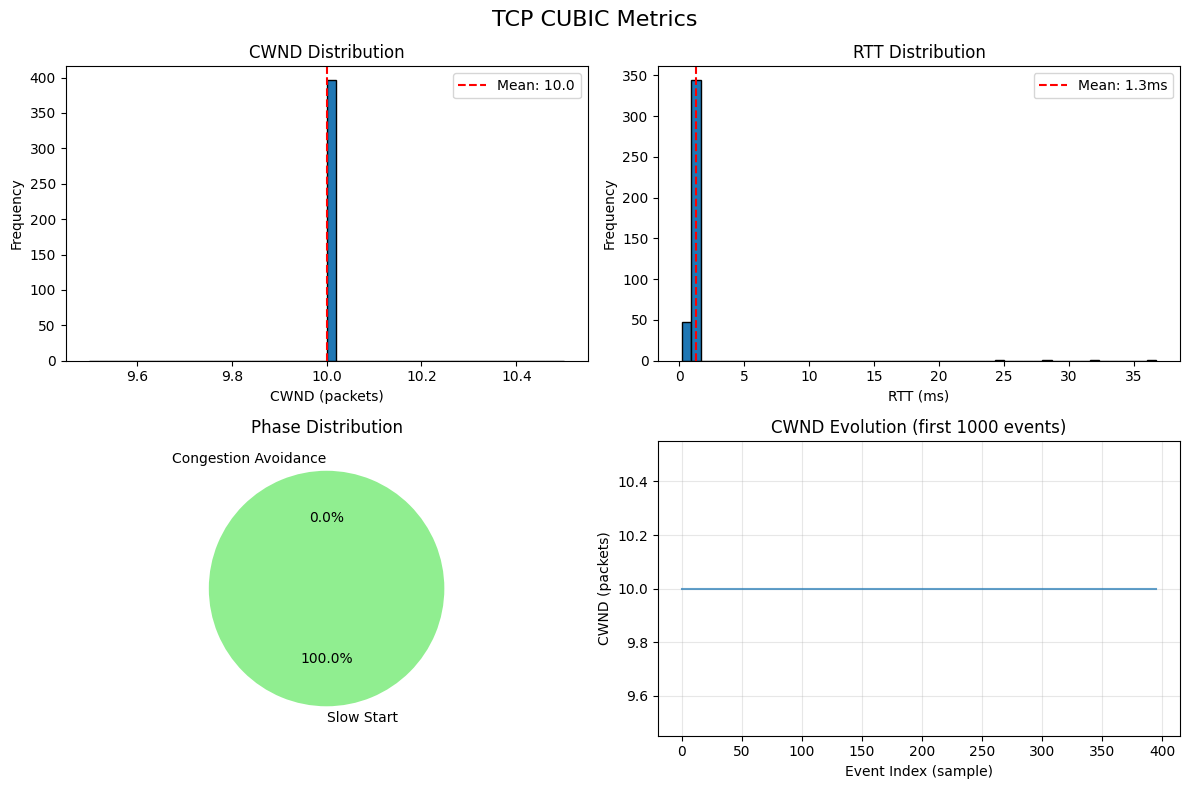


[6] CROSS-HOOK ANALYSIS
----------------------------------------
Congestion Control Correlation:
  CUBIC algorithm assignments: 11
  CUBIC metric events: 796
  Events per assignment: 72.4
Overall Health Score: 68.75156054931335/100
Issues Found:
  • Packet drops: 0.12%
  • Connection failures: 900.0%
  • Excessive slow start: 100.0%

Recommendations:
  • Check network interface: ethtool -S <interface>
  • Review firewall rules: iptables -L -n -v
  • Excessive slow start, consider:
    - Enable HyStart: sysctl -w net.ipv4.tcp_cubic_hystart=1
    - Tune slow start threshold


In [9]:
iperf_data = analyze_tcp_hooks(data, "iperf3")

In [10]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
data = collect.stop_collection()


TCP ANALYSIS: REDIS-SERVER
✓ Loaded tcp_v4_rcv: 10,864 events
✓ Loaded tcp_state_process: 21 events
✓ Loaded tcp_v4_connect: 0 events
✓ Loaded tcp_congestion_control: 11 events
✓ Loaded tcp_cubic: 3,712 events

[1] TCP PACKET RECEIVE (tcp_v4_rcv)
----------------------------------------
Packets received (entry events): 2,714
Total events recorded: 10,864
Events per packet: 4.00

Branch Distribution (% of packets):
  entry               :   2714 (100.0% of packets)
  time_wait           :   2714 (100.0% of packets)
  new_syn_recv        :   2714 (100.0% of packets)
  established_proc    :   2714 (100.0% of packets)
  socket_busy         :      8 (  0.3% of packets)

Performance Metrics:
  Fast path: 2,714 (100.0% of packets)
  Slow path: 8 (0.3% of packets)
  Listen state: 0 (0.0% of packets)
  ✓ No packet drops

Top Processes:
  redis-server        :   2714 packets

[2] TCP STATE MACHINE (tcp_state_process)
----------------------------------------
Event Types:
  PROCESSING     :     1

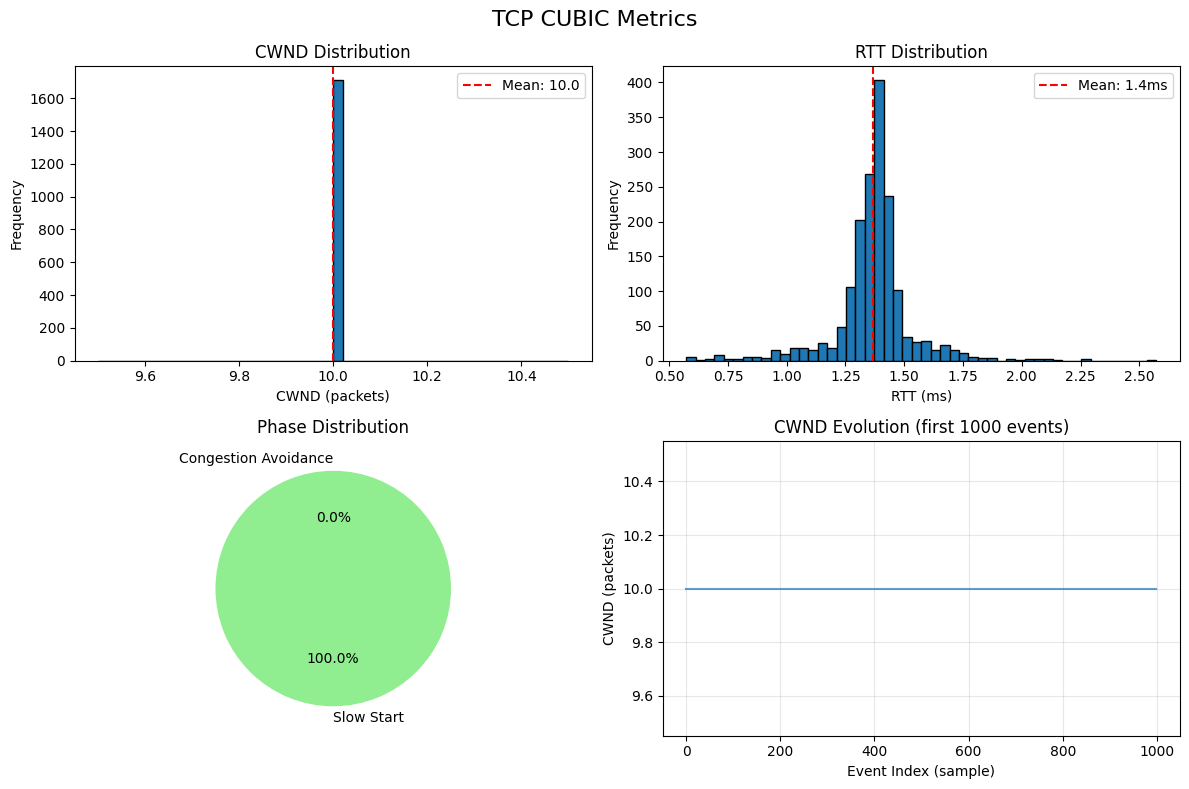


[6] CROSS-HOOK ANALYSIS
----------------------------------------
Congestion Control Correlation:
  CUBIC algorithm assignments: 9
  CUBIC metric events: 3,712
  Events per assignment: 412.4
Overall Health Score: 90/100
Issues Found:
  • Excessive slow start: 100.0%

Recommendations:
  • Excessive slow start, consider:
    - Enable HyStart: sysctl -w net.ipv4.tcp_cubic_hystart=1
    - Tune slow start threshold


In [11]:
redis_data = analyze_tcp_hooks(data, "redis-server")

In [12]:
# Create collector with XSBench configuration
collect = Collector("./config/xsbench.yaml")

# Start collection and run XSBench
print("Starting collection with XSBench workload...")
collect.start_collection(None)

# Wait for XSBench to complete
print("Running XSBench benchmark...")
data = collect.stop_collection()




Starting collection with XSBench workload...
Running XSBench benchmark...


In [13]:
xsbench_data = analyze_tcp_hooks(data, "XSBench")


TCP ANALYSIS: XSBENCH
✓ Loaded tcp_v4_rcv: 0 events
✓ Loaded tcp_state_process: 0 events
✗ No tcp_v4_connect data
✗ No tcp_congestion_control data
✓ Loaded tcp_cubic: 0 events

[6] CROSS-HOOK ANALYSIS
----------------------------------------
Overall Health Score: 100/100
✓ No significant issues detected

Recommendations:
